# Lab 2: Temporal Difference learning



This lab is divided into two sections, in the first part (based on the [reinforcement learning](https://www.neuromatchacademy.org/syllabus) neuromatch exercise) you will learn how to estimate state-value functions in a classical conditioning paradigm using Temporal Difference (TD) learning and examine TD-errors at the presentation of the conditioned and unconditioned stimulus (CS and US) under different CS-US contingencies. 
In the second part you will implement Q-learning algorithm in a grid-based map where the agent has to reach a target location.


## 1) TD error and learning

You will work with the classical conditioning environment which is composed of a sequence of states that the agent deterministically transitions through. Starting at State 0, the agent moves to State 1 in the first step, from State 1 to State 2 in the second, and so on. These states represent time in the tapped delay line representation.

Within each episode, the agent is presented with a CS and an US (reward).

The CS is always presented at 1/4 of the total duration of the trial. The US (reward) is then delivered after the CS. The interval between the CS and the US is specified by reward_time.

The agent's goal is to learn to predict expected rewards from each state in the trial.

### Helper functions

Let's run the following cells to import the libraries and the helper functions for the classical conditioning environment. As the first part of the lab contains interactive exercises, you need `ipywidgets` which you can install with conda:

```python
conda install -c conda-forge ipywidgets
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'

In [3]:
# @title Helper functions
from matplotlib import ticker

def plot_value_function(V, ax=None, show=True):
  """Plot V(s), the value function"""
  if not ax:
    fig, ax = plt.subplots(figsize=(10,8))

  ax.stem(V, use_line_collection=True)
  ax.set_ylabel('Value')
  ax.set_xlabel('State')
  ax.set_title("Value function: $V(s)$")

  if show:
    plt.show()

def plot_tde_trace(TDE, ax=None, show=True, skip=400):
  """Plot the TD Error across trials"""
  if not ax:
    fig, ax = plt.subplots(figsize=(10,8))

  indx = np.arange(0, TDE.shape[1], skip)
  im = ax.imshow(TDE[:,indx])
  positions = ax.get_xticks()
  # Avoid warning when setting string tick labels
  ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
  ax.set_xticklabels([f"{int(skip * x)}" for x in positions])
  ax.set_title('TD-error over learning')
  ax.set_ylabel('State')
  ax.set_xlabel('Iterations')
  ax.figure.colorbar(im).set_label('TD-error')
  if show:
    plt.show()

def learning_summary_plot(V, TDE):
  """Summary plot for Ex1"""
  fig, (ax1, ax2) = plt.subplots(figsize=(10,8), nrows = 2, gridspec_kw={'height_ratios': [1, 2]})

  plot_value_function(V, ax=ax1, show=False)
  plot_tde_trace(TDE, ax=ax2, show=False)
  plt.tight_layout()

#@title Default title text
class ClassicalConditioning:

    def __init__(self, n_steps, reward_magnitude, reward_time):

        # Task variables
        self.n_steps = n_steps
        self.n_actions = 0
        self.cs_time = int(n_steps/4) - 1

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = None
        self.reward_probability = None
        self.reward_time = None

        self.set_reward(reward_magnitude, reward_time)

        # Time step at which the conditioned stimulus is presented

        # Create a state dictionary
        self._create_state_dictionary()

    def set_reward(self, reward_magnitude, reward_time):

        """
        Determine reward state and magnitude of reward
        """
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0

        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]

    def get_outcome(self, current_state):

        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1:
            next_state = current_state + 1
        else:
            next_state = 0

        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0

        return next_state, reward

    def _create_state_dictionary(self):

        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:

        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else:
                d += 1 # Time in delay
                self.state_dict[s] = [1,d]



### Main concepts

We start by defining the Return $G_t$ or the sum of all the rewards starting from time $t$:
$$ G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k+1} = r_{t+1} + \gamma G_{t+1}$$
where $\gamma [0,1]$  is the discount factor and controls the importance of the future rewards.
Although we do not know the value of the Return at time $t$, the agent's goal is to make a learned estimation of it starting from any given state. This is also known as the Value function $V_{\pi}(s_t=s)$ or the expectation of the return starting from state $s$ and following a policy $\pi$ (the policy tells which action to take at each state $s$). More formally:
$$ V_{\pi}(s_t=s) = E[G_t | s_t = s, a_t \sim \pi] $$
$$ = E[r_{t+1} + \gamma G_{t+1}| s_t = s, a_t \sim \pi]$$
$$ = E[r_{t+1} + \gamma V_{\pi}(s_{t+1})| s_t = s, a_t \sim \pi]$$

As you can see, the Value depends on the Value at the next time step in a recursive manner. Since we don't know the true value $G_{t+1}$, thanks to the Markov assumption, we can bootstrap $V(s_{t+1})$ and use it to replace $G_{t+1}$.
This difference between the value at the next time step and the current time step is called the Temporal Difference (TD)-error:
$$\delta_t = r_{t+1} + \gamma V_{\pi}(s_{t+1}) - V(s_t)$$

Hence, the update rule for the value can be written as:
$$ V(s_t) = V(s_t) + \alpha \delta_t$$
where $\alpha$ is the learning rate.

### 1.1) TD-learning with guaranteed rewards

Implement TD-learning to estimate the state-value function in the classical-conditioning world with guaranteed rewards, with a fixed magnitude, at a fixed delay after the conditioned stimulus, CS. Save TD-errors over learning (i.e., over trials) so we can visualise them afterwards.

In order to simulate the effect of the CS, you should only update $V(s_t)$
 during the delay period after CS. This period is indicated by the boolean variable ```is_delay```. This can be implemented by multiplying the expression for updating the value function by ```is_delay```.

Use the provided code to estimate the value function.

In [4]:
# Complete the lines to calculate TD-error and to update the value V
def td_learner(env, n_trials, gamma=0.98, alpha=0.001):
  """ Temporal Difference learning

  Args:
    env (object): the environment to be learned
    n_trials (int): the number of trials to run
    gamma (float): temporal discount factor
    alpha (float): learning rate

  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """
  V = np.zeros(env.n_steps) # Array to store values over states (time)
  TDE = np.zeros((env.n_steps, n_trials)) # Array to store TD errors

  for n in range(n_trials):
    state = 0 # Initial state
    for t in range(env.n_steps):
      # Get next state and next reward
      next_state, reward = env.get_outcome(state)
      # Is the current state in the delay period (after CS)?
      is_delay = env.state_dict[state][0]
        
      #######################################################
      ##
      ## Complete the following lines 
      ##
      #######################################################
      # Write an expression to compute the TD-error
      TDE[state, n] = reward + gamma * V[next_state] - V[state]

      # Write an expression to update the value function
      V[state] += TDE[state, n] * alpha * is_delay

      # Update state
      state = next_state

  return V, TDE

Run the cell below to execute the TD-learner and to visualise the outcome.

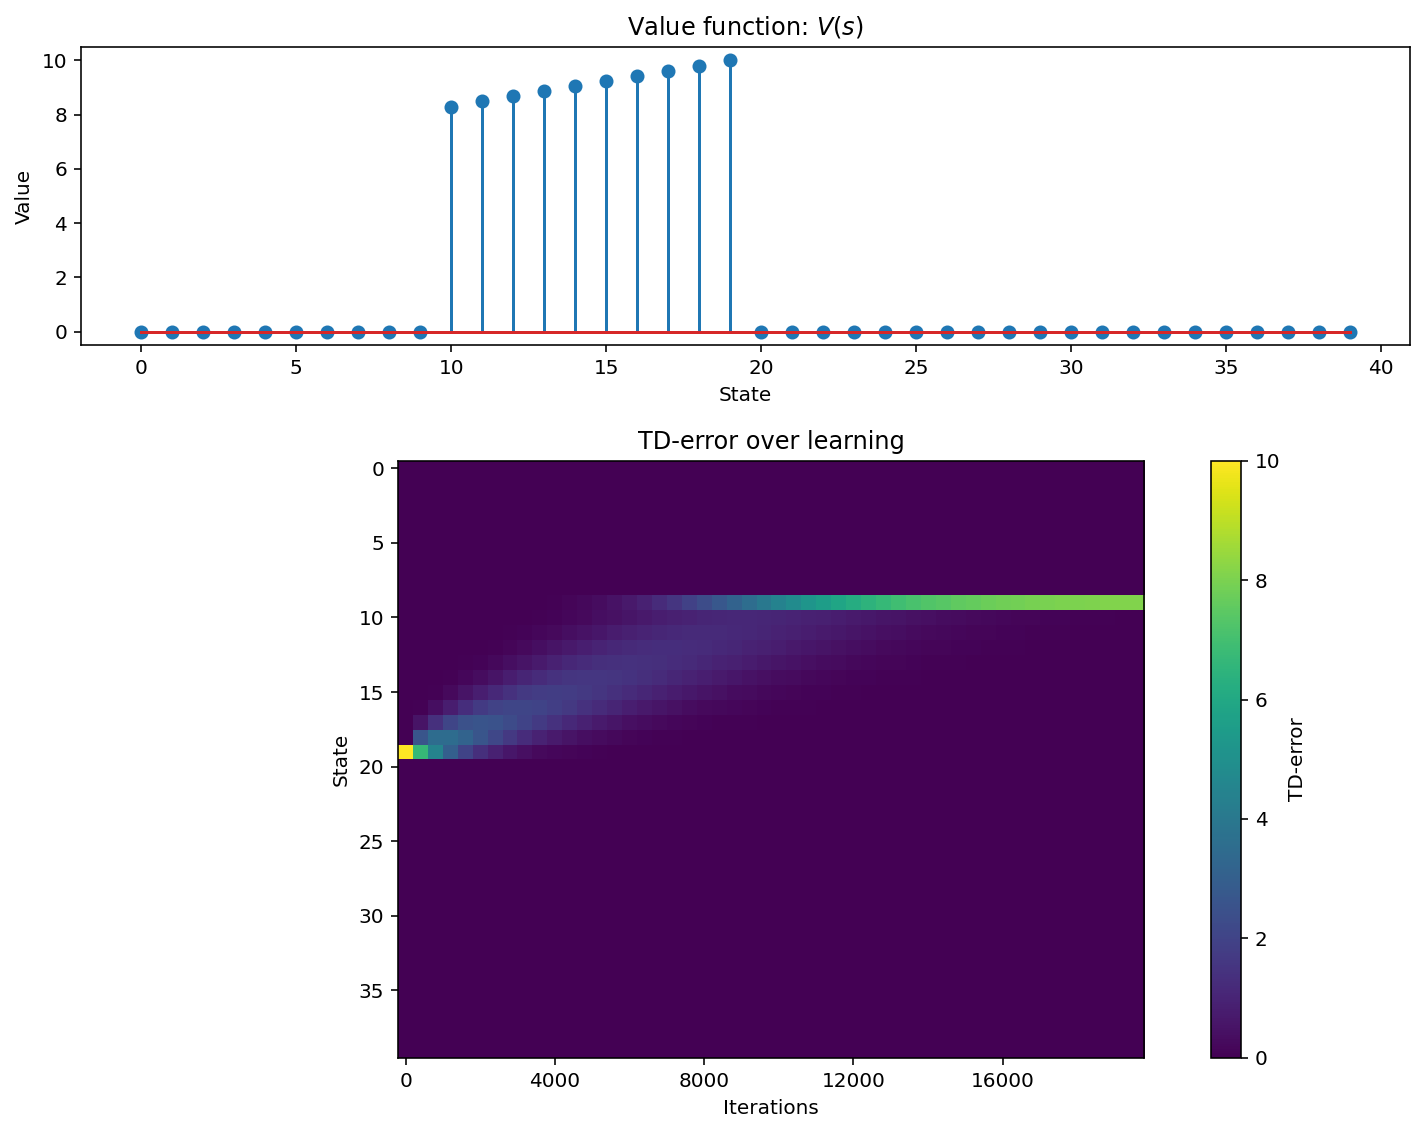

In [5]:
env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
V, TDE = td_learner(env, n_trials=20000)
learning_summary_plot(V, TDE)

### 1.2) US to CS Transfer

During classical conditioning, the subject's behavioral response (e.g., salivating) transfers from the unconditioned stimulus (US; like the smell of tasty food) to the conditioned stimulus (CS) that predicts it. Reward prediction errors play an important role in this process by adjusting the value of states according to their expected, discounted return.

Use the widget below to examine how reward prediction errors change over time. Before training (orange line), only the reward state has high reward prediction error. As training progresses (blue line, slider), the reward prediction errors shift to the conditioned stimulus, where they end up when the trial is complete (green line).

Dopamine neurons, which are thought to carry reward prediction errors in vivo, show [notably similar behavior](https://www.nature.com/articles/nn0898_304).

In [6]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

n_trials = 20000

@widgets.interact
def plot_tde_by_trial(trial = widgets.IntSlider(value=5000, min=0, max=n_trials-1 , step=1, description="Trial #")):
  if 'TDE' not in globals():
    print("Complete Exercise 1 to enable this interactive demo!")
  else:

    fig, ax = plt.subplots(figsize=(10,6))
    ax.axhline(0, color='k') # Use this + basefmt=' ' to keep the legend clean.
    ax.stem(TDE[:, 0], linefmt='C1-', markerfmt='C1d', basefmt=' ',
            label="Before Learning (Trial 0)",
            use_line_collection=True)
    ax.stem(TDE[:, -1], linefmt='C2-', markerfmt='C2s', basefmt=' ',
            label="After Learning (Trial $\infty$)",
            use_line_collection=True)
    ax.stem(TDE[:, trial], linefmt='C0-', markerfmt='C0o', basefmt=' ',
            label=f"Trial {trial}",
            use_line_collection=True)

    ax.set_xlabel("State in trial")
    ax.set_ylabel("TD Error")
    ax.set_title("Temporal Difference Error by Trial")
    ax.legend()

interactive(children=(IntSlider(value=5000, description='Trial #', max=19999), Output()), _dom_classes=('widge…

### 1.3) Learning Rates and Discount Factors

Our TD-learning agent has two parameters that control how it learns: $\alpha$, the learning rate, and $\gamma$
, the discount factor. In Exercise 1, we set these parameters to $\alpha=0.001$
and $\gamma=0.98$ for you. Here, you'll investigate how changing these parameters alters the model that TD-learning learns.

Before enabling the interactive demo below, take a moment to think about the functions of these two parameters. $\alpha$ controls the size of the Value function updates produced by each TD-error. In our simple, deterministic world, will this affect the final model we learn? Is a larger $\alpha$ necessarily better in more complex, realistic environments?

The discount rate $\gamma$ applies an exponentially-decaying weight to returns occuring in the future, rather than the present timestep. How does this affect the model we learn? What happens when $\gamma=0$
 or $\gamma≥1$ ?

Use the widget to test your hypotheses.

In [7]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact
def plot_summary_alpha_gamma(alpha = widgets.FloatSlider(value=0.0001, min=0.0001, max=0.1, step=0.0001, readout_format='.4f', description="alpha"),
                             gamma = widgets.FloatSlider(value=0.980, min=0, max=1.1, step=0.010, description="gamma")):
  env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
  try:
    V_params, TDE_params = td_learner(env, n_trials=20000, gamma=gamma, alpha=alpha)
  except NotImplementedError:
    print("Finish Exercise 1 to enable this interactive demo")

  learning_summary_plot(V_params,TDE_params)

interactive(children=(FloatSlider(value=0.0001, description='alpha', max=0.1, min=0.0001, readout_format='.4f'…

### Recap

In this notebook, we have developed a simple TD Learner and examined how its state representations and reward prediction errors evolve during training. By manipualting its environment and parameters (α
, γ
), you developed an intuition for how it behaves.

This simple model closely resembles the behavior of subjects undergoing classical conditioning tasks and the dopamine neurons that may underlie that behavior. You may have implemented TD-reset or used the model to recreate a common experimental error. The update rule used here has been extensively studied for more than 70 years as a possible explanation for artificial and biological learning.

However, you may have noticed that something is missing from this notebook. We carefully calculated the Value of each state, but did not use it to actually do anything. Using Values to plan Actions is coming up next!

## 2) Q-learning algorithm

While Values are related to each state as a whole, we now introduce Q-Value which is the value of each state-action pair. Q-value allows to measure the quality of each action from a given state. Hence, choosing an action corresponding to higher Q-value can improve the agent's planning.
Among the various algorithms, Q-learning utilises the temporal-difference learning to directly approximate the optimal action-value function (that is, the action-value function of the optimal policy), no matter what policy is followed. The pseudocode taken from the book by Sutton and Barto is presented below:

<img src="q-learning.png" width="600">

Q-learning is an off-policy algorithm as two different policy are utilised to behave and to update the Q-value.
In particular, the behavioural policy (the actions chosen by the agent while moving in the environment) is $\epsilon - greedy$ which is different from the policy utilised for the bootstrapped Q-value $Q(S',a)$. The policy of $Q(S',a)$ is $greedy$ as it choses the max action.
This off-policy nature can help to explore better as the agent is not constrained to the same policy while navigating the environment and while updating the Q-value $Q(S,A)$.

The next task consists of implementing the Q-learning algorithm for an agent navigating a grid-world environment. The agent's aim is to reach the target grid-location. Moreover the environment presents walls where the agent cannot stay. The figure below shows the environment as well as the agent and the target. The starting point is always top-left corner.

<img src="env.png" width="400">

The walls are represented by the purple color, the agent's starting position is the top-left corner and the target is the green grid. The agent's position is the dark blue cell. The yellow grids are the valid parts where the agent can navigate.

The following cell contains the class `MDP` which implements the environment class for the grid-world. The cell has been already implemented, just make sure to run before proceeding to the next where you will implement parts of the Q-learning algorithm.

In [8]:
import copy 

class MDP:
    def __init__(self):
        
        #possible states
        self.S = [(x,y) for x in range(6) for y in range(6)]
        
        # possible actions 
        self.A = ["UP","DOWN","LEFT","RIGHT"]
        
        self.start = (0,0)
        self.terminal = (2,2)
        self.walls = [(0,1), (1,1), (2,1), (3,1), (3,2), (3,3), (3,4), (2,4)]
        
        self.prob = 1.0 # change to make the env stochastic, 1=deterministic
        
        
        self.agentColor = 0.3
        self.startColor = 0.8
        self.terminalColor = 0.5
        self.wallColor = 0.1
        self.N = 6
        self.agentPosition = self.start
        
        self.world = np.zeros((self.N,self.N))
        
    def showMap(self):
        self.world = np.ones((self.N,self.N))
        
        if(self.agentPosition != self.start):
            self.world[self.start[0], self.start[1]] = self.startColor
        if(self.agentPosition != self.terminal):
            self.world[self.terminal[0], self.terminal[1]] = self.terminalColor
            
        self.world[self.agentPosition[0], self.agentPosition[1]] = self.agentColor
        
        for wall in self.walls:
            self.world[wall] = self.wallColor
            
        fig, ax = plt.subplots(figsize=(self.N*3,self.N))
        
        ax.imshow(self.world)
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=3)
        ax.set_xticks(np.arange(-.5, self.N, 1));
        ax.set_yticks(np.arange(-.5, self.N, 1));
        
    def setAgent(self, position):
        self.agentPosition = position

    def reset(self):
        # to do
        return self.start
    
    def probNextStates(self, initState, action):
        """ Return the next state probability for the MDP as a dictionary.

        Keyword Arguments:
        initState -- The current state s.
        action -- The chosen action in state s, a.

        """
        nextStateProbs = {}
        if initState != self.terminal:
            
            # Get all the possible actions
            possibleDestinations = [(initState[0], max(0,initState[1]-1)),(initState[0], min(5,initState[1]+1)),
                                    (max(0,initState[0]-1), initState[1]), (min(5,initState[0]+1), initState[1])]

            for possibleState in possibleDestinations:

                if possibleState in self.walls:
                    possibleDestinations.remove(possibleState)
                    possibleDestinations.append(initState)
            
            intendedDestination = None
            
            if action == "UP":
                intendedDestination = (max(0,initState[0]-1), initState[1])
            elif action == "DOWN" :
                intendedDestination = (min(5,initState[0]+1), initState[1])
            elif action == "LEFT":
                intendedDestination = (initState[0], max(0,initState[1]-1))
            else:
                intendedDestination = (initState[0], min(5,initState[1]+1))
            
            if intendedDestination in self.walls:
                intendedDestination = initState
        
            # assign prob to remaining possible states
            if len(possibleDestinations) > 1:
                otherDestinationProbs = (1.0 - self.prob) / len(possibleDestinations)
            
            for possibleState in possibleDestinations:
                if not possibleState in nextStateProbs.keys():
                    nextStateProbs[possibleState] = 0.0
                nextStateProbs[possibleState] += otherDestinationProbs
                
            nextStateProbs[intendedDestination] += self.prob

        else:
            nextStateProbs = {initState[0]:1.0}
            
        return nextStateProbs
    
    def step(self, state, action):
        prevState = state
        prob_dict = self.probNextStates(state, action)
        nextStates = list(prob_dict.keys())
        nextStateProb = list(prob_dict.values())
        ind = np.random.choice( range(len(nextStates)), p=nextStateProb )
        nextState = nextStates[ind]
        reward = 0.0
        if nextState == self.terminal:
            status = 'done'
            reward = 1.0
#         elif nextState in self.walls:
#             status = 'done'
#             reward = -1.0
        else:
            status = 'moving'
        
        return nextState, reward, status

The aim is to find an optimal policy that can navigate the agent towards the target location.
We will achieve that through the Q-Learning algorithm. The next cell presents the `QLearningAgent()` class. You have to fill in the remaining lines of code and leave the rest of the code as it is. In particular, your aim is to complete the `learn()` method implementing the Q-learning step. 

Next, you will do the same with the `act()` method. This method will return the optimal action that the agent needs to execute, however, you will implement $\epsilon$-greedy which allows to balance the exploitation vs exploration dilemma. 

In [21]:
class QLearningAgent():
    def __init__(self, learningRate, discountFactor, epsilon, initVals=0.0):
        self.learningRate = learningRate
        self.gamma = discountFactor
        self.epsilon = epsilon
        self.episode_sar = []
        
        self.possibleActions = ["UP","DOWN","LEFT","RIGHT"]
        self.terminal = (2,2)


        self.allStates = [(x, y) for x in range(6) for y in range(6)]
        self.walls = [(0,1), (1,1), (2,1), (3,1), (3,2), (3,3), (3,4), (2,4)]

        self.S = list(filter(lambda i: i not in self.walls, self.allStates))
        

        self.Q = dict.fromkeys(self.S)

        # initialise all Q(S,A) to 0.0
        for state in self.S:
            self.Q[state] = {self.possibleActions[i]: initVals for i in range(len(self.possibleActions))}
    
    ##############################################
    ##
    ## Complete the next two methods: learn() and act().
    ##
    ##############################################
    def learn(self):
        step = self.episode_sar # state, action, nextState, reward
        # step[0] = state, step[1] = action, step[2] = nextState, step[3] = reward

        opt_action = max(self.Q[step[2]], key=self.Q[step[2]].get)
        
        # compute next state value
        max_value = self.gamma * self.Q[step[2]][opt_action]

        Q_before = self.Q[step[0]][step[1]]
        
        # update Q-value
        self.Q[step[0]][step[1]] +=  self.learningRate * (step[3] + max_value - Q_before)

        return self.Q[step[0]][step[1]]-Q_before

    def act(self):
        # return action associated with current state, following policy

        # give to all action prob of epsilon/possibleActions
        action_probs = self.epsilon / len(self.possibleActions)

        # dict of action with probabilities {action: probability}
        prob_dict = dict.fromkeys(self.possibleActions, action_probs)

        opt_action = max(self.Q[self.curState], key=self.Q[self.curState].get)

        max_value = self.Q[self.curState][opt_action]

        # opt_dict stores all the equally optimal actions {action: value}
        opt_list = []
        for action in self.Q[self.curState]:
            value = self.Q[self.curState][action]
            if value == max_value:
                opt_list.append(action)

        # select optimal randomly (arbitrary) from all the optimal actions
        # shuffle it and pick the first one
        np.random.shuffle(opt_list)
        opt_action = opt_list[0]

        # change the probability of th optimal action
        prob_dict[opt_action] = 1 - self.epsilon + action_probs

        action_selected = np.random.choice(list(prob_dict.keys()), p=list(prob_dict.values()))

        return action_selected
    
    ##############################################
    ##
    ## The End. Leave the remaining code as it is.
    ##
    ##############################################

#     def toStateRepresentation(self, state):
# #         self.defendState = state[1]
#         return state

    def setState(self, state):
        self.curState = state

    def setExperience(self, state, action, reward, status, nextState):
        self.episode_sar = state, action, nextState, reward

    def reset(self):
        self.episode_sar = []
        
    def setLearningRate(self, learningRate):
        self.learningRate = learningRate

    def setEpsilon(self, epsilon):
        self.epsilon = epsilon
    
    def computeHyperparameters(self, numTakenActions, episodeNumber):
        # TO-DO
        # return alpha, eps
        pass

    def showQVal(self, N):
        world = np.ones((N,N))
        world[self.terminal[0], self.terminal[1]] = 0.5
        
        for wall in self.walls:
            world[wall] = 0.1
            
        fig, ax = plt.subplots(figsize=(N*2,N*2))
        
        ax.imshow(world)
        ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=3)
        ax.set_xticks(np.arange(-.5, N, 1));
        ax.set_yticks(np.arange(-.5, N, 1));
        
        fc = (.2, .5, 1.0)
        bbox_propsA = dict(boxstyle="round", fc="w", pad=.1, ec="1.0", alpha=0.0)
        bbox_propsR = dict(boxstyle="rarrow", pad=2.0, fc=(.9, .9, .9), ec="b", lw=2)
        bbox_props = dict(boxstyle="rarrow", pad=2.0, fc=(.9, .9, .9), ec="b", lw=2,)
        bbox_propsL = dict(boxstyle="larrow", pad=2.0, fc=(.9, .9, .9), ec="b", lw=2)
        bbox_R_best = dict(boxstyle="rarrow", pad=2.0, fc=(.2, .5, 1.0), ec="b", lw=2)
        bbox_UD_best = dict(boxstyle="rarrow", pad=2.0, fc=(.2, .5, 1.0), ec="b", lw=2,)
        bbox_L_best = dict(boxstyle="larrow", pad=2.0, fc=(.2, .5, 1.0), ec="b", lw=2)

        
        for q in self.Q:
            if q == self.terminal:
                continue
            opt_action = max(self.Q[q],key=self.Q[q].get)
#             print('{:<20} '.format(opt_action), end="")
#             print(" ")
            if opt_action=="DOWN":
                ax.text(q[1], q[0]+0.3, " ", ha="center", va="center", size=6, rotation=-90, bbox=bbox_UD_best)
            else:
                ax.text(q[1], q[0]+0.3, " ", ha="center", va="center", size=6, rotation=-90, bbox=bbox_props)
            
            if opt_action=="UP":
                ax.text(q[1], q[0]-0.3, " ", ha="center", va="center", size=6, rotation=90, bbox=bbox_UD_best)
            else:
                ax.text(q[1], q[0]-0.3, " ", ha="center", va="center", size=6, rotation=90, bbox=bbox_props)
            if opt_action=="RIGHT":
                ax.text(q[1]+0.3, q[0], " ", ha="center", va="center", size=6, rotation=0, bbox=bbox_R_best)
            else:
                ax.text(q[1]+0.3, q[0], " ", ha="center", va="center", size=6, rotation=0, bbox=bbox_propsR)
            if opt_action=="LEFT":
                ax.text(q[1]-0.3, q[0], " ", ha="center", va="center", size=6, rotation=0, bbox=bbox_L_best)
            else:
                ax.text(q[1]-0.3, q[0], " ", ha="center", va="center", size=6, rotation=0, bbox=bbox_propsL)
            
            
            ax.text(q[1], q[0]+0.3, '{:0.2f}'.format(self.Q[q]["DOWN"]), ha="center", va="center", size=10,
                    rotation=0, bbox=bbox_propsA)
            ax.text(q[1], q[0]-0.3, '{:0.2f}'.format(self.Q[q]["UP"]), ha="center", va="center", size=10,
                    rotation=0, bbox=bbox_propsA)
            ax.text(q[1]+0.3, q[0], '{:0.2f}'.format(self.Q[q]["RIGHT"]), ha="center", va="center", size=10,
                    rotation=0, bbox=bbox_propsA)
            ax.text(q[1]-0.3, q[0], '{:0.2f}'.format(self.Q[q]["LEFT"]), ha="center", va="center", size=10,
                    rotation=0, bbox=bbox_propsA)


After having implemented the previous code, run the next cell to initialise the environment and the agent.

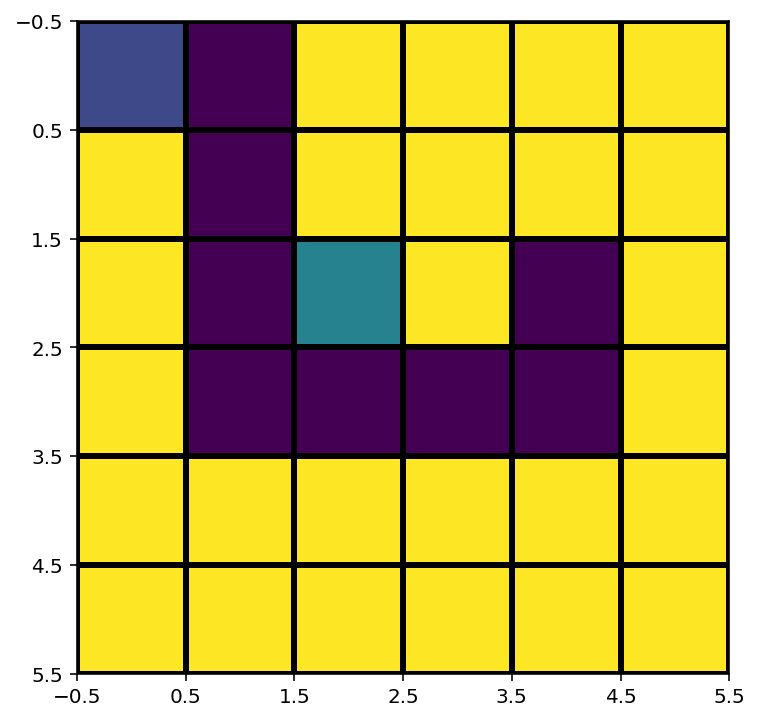

In [22]:
environment = MDP()
state = environment.reset()
environment.showMap()

# Initialize a Q-Learning Agent
agent = QLearningAgent(learningRate = 0.1, discountFactor = 0.9, epsilon = 0.01)
numEpisodes = 1000 #20000


numTakenActions = 0

Finally, run the following cell to start training Q-learning agent, leave the uncommented part as it is, we will return to it later.

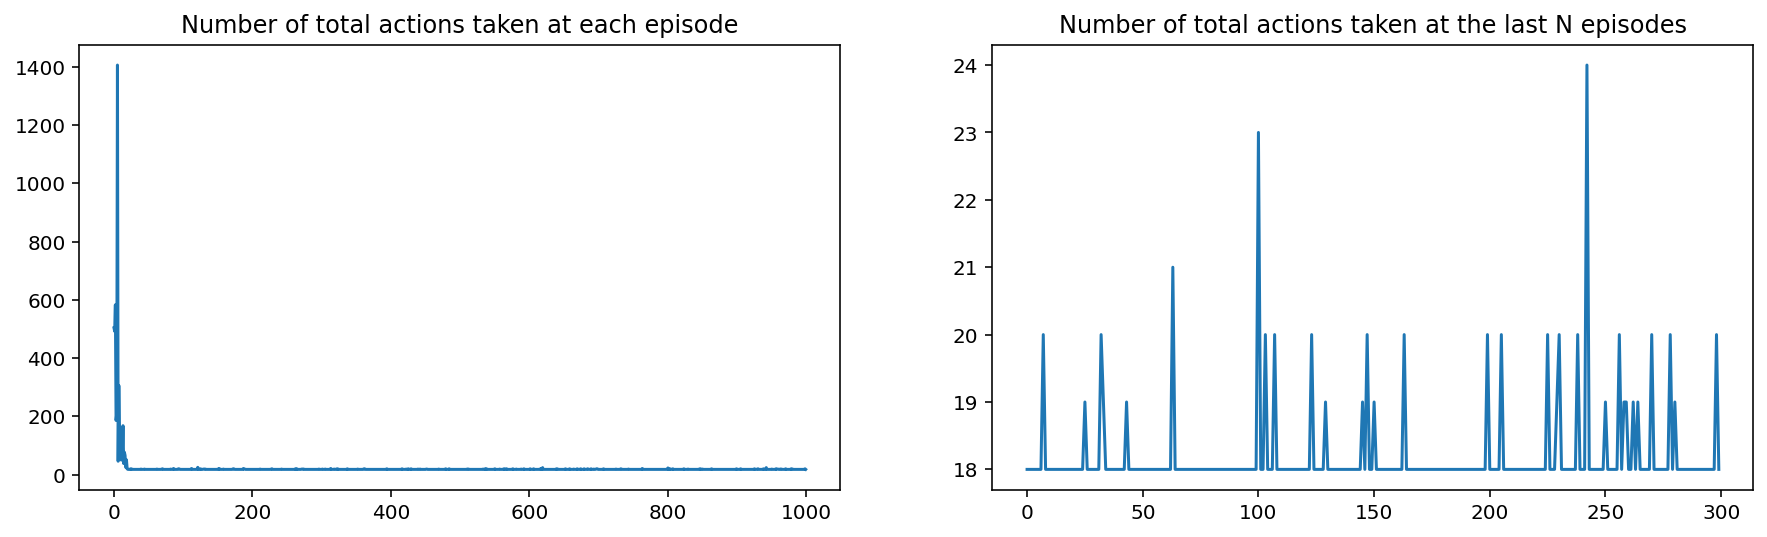

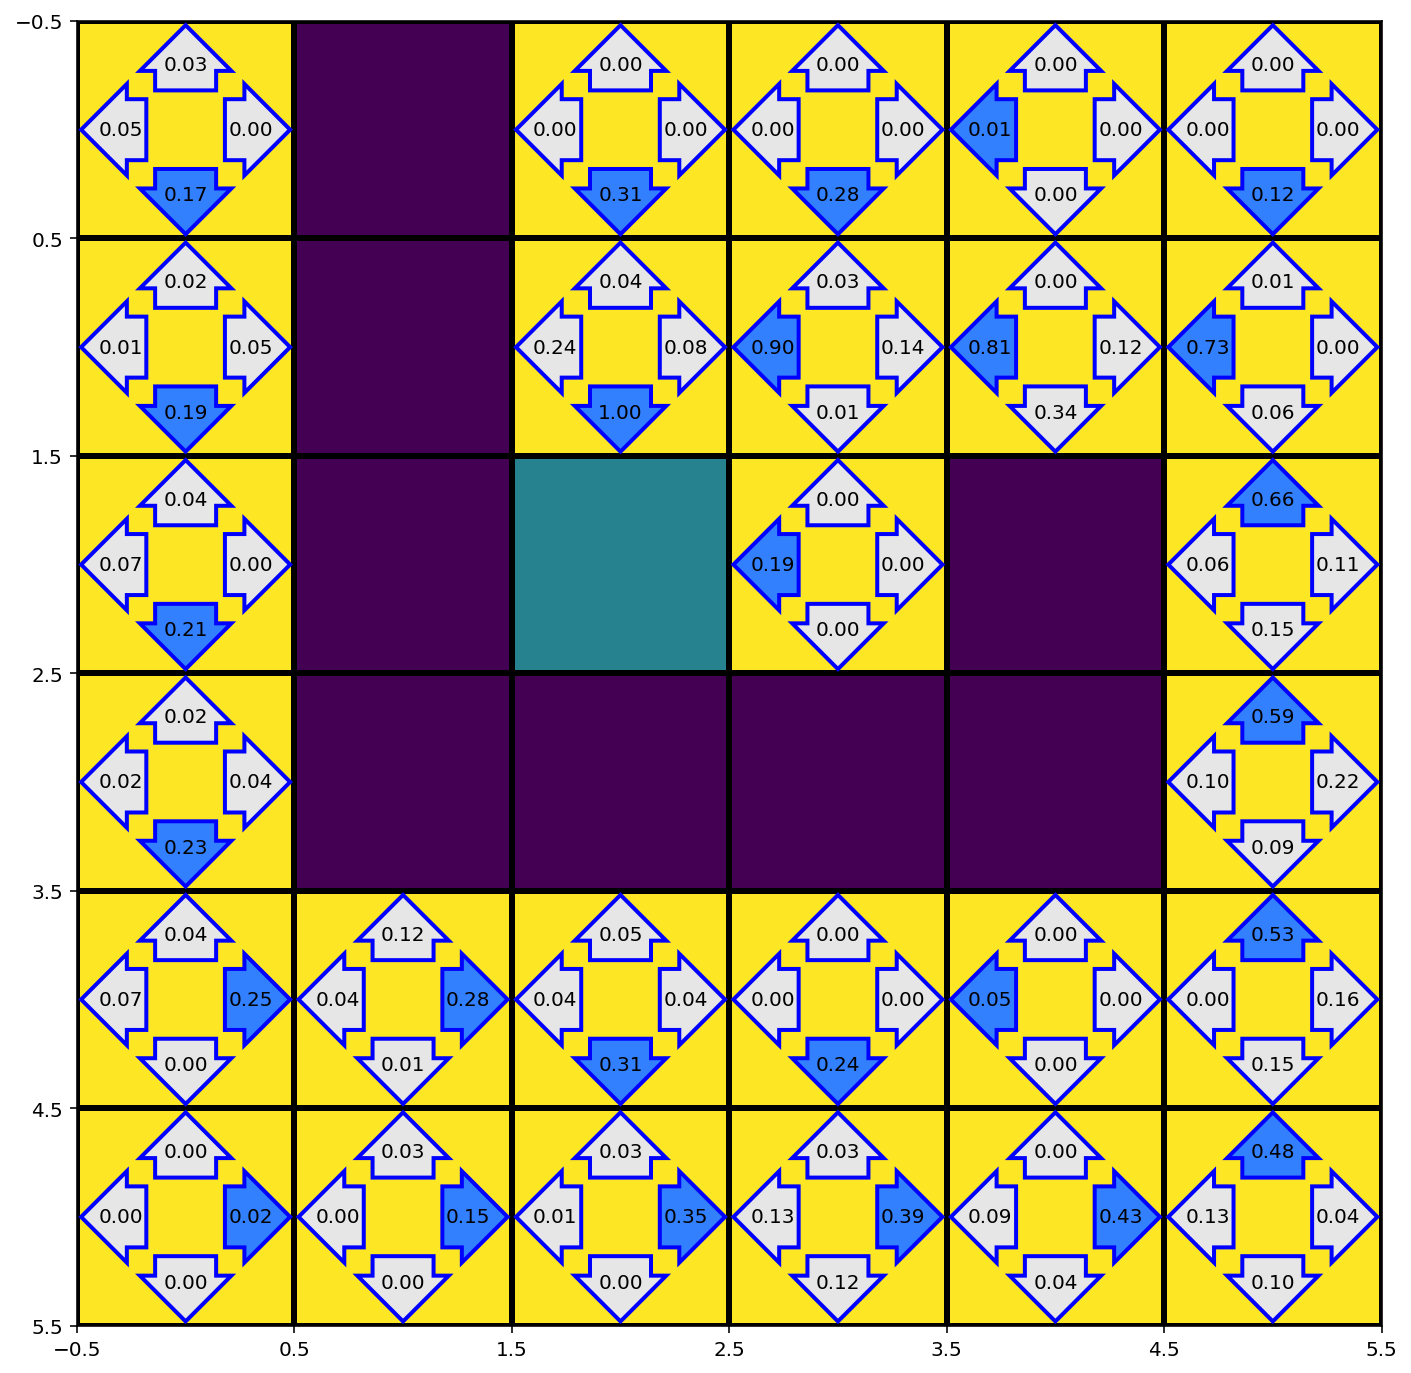

In [23]:
# Run training using Q-Learning

plt.figure(figsize=(15,9))

numActionsList = []
episodeAction = 0

for episode in range(numEpisodes):
    status = 0
    episodeAction = 0
    observation = environment.reset()
    status = 'moving'

    while status=='moving':
        ###### tune hyperparameters - leave it for later #######
        # learningRate, epsilon = agent.computeHyperparameters(numTakenActions, episode)
        # agent.setEpsilon(epsilon)
        # agent.setLearningRate(learningRate)
        ########################################################
        obsCopy = copy.copy(observation)
        agent.setState(obsCopy)
        action = agent.act()
        numTakenActions += 1
        episodeAction += 1

        nextObservation, reward, status = environment.step(obsCopy, action)
        agent.setExperience(obsCopy, action, reward, status, nextObservation)
        update = agent.learn()

        observation = nextObservation
        
        # commenting as it slows down the overall process 
        # environment.setAgent(position=observation)
        # environment.showMap()
    
    numActionsList.append(episodeAction)
    
plt.subplot(2,2,1)
plt.plot(numActionsList)
plt.title('Number of total actions taken at each episode')

plt.subplot(2,2,2)
plt.plot(numActionsList[-300:]) # select last N episodes 
plt.title('Number of total actions taken at the last N episodes')

# show the environment with each Q-value as well as the optimal Q-value.
agent.showQVal(6)

Zoom more in the last $N$ episodes and check how the number of actions changes over the episodes.

What is the number of optimal actions? You might observe some jumps, why are you observing this behaviour?

In [5]:
N = 100

plt.figure(figsize=(15,9))
# plt.clf()
plt.subplot(2,2,1)
# plt.cla()
plt.plot(numActionsList)
# plt.imshow()
plt.title('Number of total actions taken at each episode')

plt.subplot(2,2,2)
plt.plot(numActionsList[-N:]) # select last N episodes 
plt.title('Number of total actions taken at the last N episodes')

# show the environment with each Q-value as well as the optimal Q-value.
agent.showQVal(6)

NameError: name 'plt' is not defined

# 2.1 What is the role of the different hyperparameters?

In this section we will ask you to test different hyperparameters. Lets first explore the role of the learning rate $\alpha$. Try $\alpha = 0.01$ and $\alpha=1$. What do you expect? And do you get?

In [1]:
#Add code here to test different learning rates (alpha)
'TODO'

'TODO'

# 2.1.1 Discount factor
Now lets explore the role of the discount factor $\gamma$. Try $\gamma = 0.01$ and $\gamma=1$. What do you expect? And do you get?

In [ ]:
#Add code here to test different discount factors (gamma)
'TODO'

# 2.1.2 Exploration vs exploitation (epsilon)
Now lets explore the role of $\epsilon$ in $\epsilon$-greedy policy. Try $\epsilon = 0.01$ and $\epsilon=1$. What do you expect? And do you get?

In [3]:
#Add code here to test different epsilons
'TODO'

'TODO'

# 2.1.3 Implement a meta hyperparameter function
Go back and uncomment the `tune hyperparameter` block. Implement the `computeHyperparameters()` function of the agent such that you can optimise the hyperparameters ($\alpha, \epsilon$) according to the number of actions taken and episode.  What do you observe?

## Conclusion
Congratulations, you have reached the end of this lab. Let's summarise what we have learnt.
* Understand temporal difference error and its relation to the learning process in the brain.
* Understand the difference between Value and Q-value functions as well as other key components of the reinforcement learning framework.
* Main steps behind Q-learning algorithm.

## References
* COMSM0075 Information Processing and the Brain: Lecture 4, Reinforcement Learning
* Sutton and Barto: Reinforcement Learning - An Introduction, Chapter 6 Temporal-Difference Learning
* [Neuromatch Academy 2020](https://www.neuromatchacademy.org)